In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [41]:
df_train_est_A = pd.read_csv('train_est_C.csv')
df_train_obs_A = pd.read_csv('train_obs_C.csv')
df_test_A = pd.read_csv('X_test_C.csv')
df_train_est_A = df_train_est_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_obs_A = df_train_obs_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_test_A = df_test_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_est_A.set_index('date_forecast', inplace=True)
df_train_obs_A.set_index('date_forecast', inplace=True)
df_test_A.set_index('date_forecast', inplace=True)
df_train_obs_A.index = pd.to_datetime(df_train_obs_A.index)
df_train_obs_A.index = pd.to_datetime(df_train_obs_A.index)


In [42]:
df = pd.concat([df_train_obs_A,df_train_est_A])
df = df.drop(columns = 'date_calc', axis = 1)
df_test_A = df_test_A.drop(columns = 'date_calc', axis = 1)


In [43]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df_test_A = df_test_A.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [44]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=24)
df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)
df_test_A = pd.DataFrame(imputer.fit_transform(df_test_A), columns = df_test_A.columns)

In [45]:
from sklearn.neighbors import LocalOutlierFactor
# Crea un modello di rilevamento delle anomalie
clf = LocalOutlierFactor(n_neighbors=20)

# Identifica i dati anomali
anomalies = clf.fit_predict(df)
df[anomalies == -1]
# Stampa i dati anomali
df = df[anomalies != -1]
df1 = df
#anomalies = clf.fit_predict(df_test_A)
#df_test_A[anomalies == -1]
# Stampa i dati anomali
##df_test_A = df_test_A[anomalies != -1]

In [46]:
scaling_columns = df1.drop(columns = 'pv_measurement').columns
scaling_columns

Index(['absolute_humidity_2mgm3', 'air_density_2mkgm3', 'ceiling_height_aglm',
       'clear_sky_energy_1hJ', 'clear_sky_radW', 'cloud_base_aglm',
       'dew_or_rimeidx', 'dew_point_2mK', 'diffuse_radW', 'diffuse_rad_1hJ',
       'direct_radW', 'direct_rad_1hJ', 'effective_cloud_coverp', 'elevationm',
       'fresh_snow_12hcm', 'fresh_snow_1hcm', 'fresh_snow_24hcm',
       'fresh_snow_3hcm', 'fresh_snow_6hcm', 'is_dayidx', 'is_in_shadowidx',
       'msl_pressurehPa', 'precip_5minmm', 'precip_type_5minidx',
       'pressure_100mhPa', 'pressure_50mhPa', 'prob_rimep', 'rain_waterkgm2',
       'relative_humidity_1000hPap', 'sfc_pressurehPa', 'snow_densitykgm3',
       'snow_depthcm', 'snow_driftidx', 'snow_melt_10minmm', 'snow_waterkgm2',
       'sun_azimuthd', 'sun_elevationd', 'super_cooled_liquid_waterkgm2',
       't_1000hPaK', 'total_cloud_coverp', 'visibilitym', 'wind_speed_10mms',
       'wind_speed_u_10mms', 'wind_speed_v_10mms', 'wind_speed_w_1000hPams'],
      dtype='object')

In [47]:
from sklearn.preprocessing import StandardScaler
norm = StandardScaler()
df =pd.DataFrame( norm.fit_transform(df[scaling_columns]), columns = df[scaling_columns].columns, index = df.index)
df_test_A =pd.DataFrame( norm.fit_transform(df_test_A[scaling_columns]), columns = df_test_A[scaling_columns].columns, index = df_test_A.index)

In [48]:
df['pv_measurement'] = df1['pv_measurement']

In [49]:
df.index = pd.to_datetime(df.index)
df['hours'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year
df_test_A.index = pd.to_datetime(df_test_A.index)
df_test_A['hours'] = df_test_A.index.hour
df_test_A['day'] = df_test_A.index.day
df_test_A['month'] = df_test_A.index.month
df_test_A['year'] = df_test_A.index.year


In [50]:
import lightgbm as lgb
model = lgb.LGBMRegressor(importance_type='split')

In [51]:
X_train = df.drop(columns = 'pv_measurement')
y_train = df['pv_measurement']

In [52]:
model.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8300
[LightGBM] [Info] Number of data points in the train set: 31599, number of used features: 42
[LightGBM] [Info] Start training from score 87.972699


LGBMRegressor()

In [53]:
feature_importance = model.feature_importances_
# Define a threshold for feature importance
threshold = 0.0005  # Adjust this value as needed

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
# Filter features above the threshold
selected_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature']

# Create a new DataFrame with the selected features
X_selected = X_train[selected_features]
X_selected['pv_measurement'] = df['pv_measurement']


In [54]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# Sample DataFrame (replace this with your own dataset)
data = X_selected

# Define the number of splits (e.g., 5 for 80-20 train-test splits)
n_splits = 3


# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)
data.shape

(31599, 36)

In [55]:
def objective(trial):
    param = {
            'metric': 'mae', 
            'random_state': 42,
            'n_estimators': trial.suggest_int('n_estimators',10,1000),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4,1e-1),
            'max_depth': trial.suggest_int('max_depth', 1,50),
            'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
            'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100),
            'verbosity': -1
        }
    model = lgb.LGBMRegressor(**param)
    for train_index, test_index in tscv.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        # Extract target variable for training and testing data
        y_train = train_data['pv_measurement']
        y_test = test_data['pv_measurement']

        # Extract features for training and testing data
        X_train = train_data.drop(columns = 'pv_measurement')
        X_test = test_data.drop(columns = 'pv_measurement')
        
        # Train the XGBoost model
        model.fit(X_train, y_train,eval_set=[(X_test,y_test)])

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Evaluate the model using Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, y_pred)
        print("Mean Absolute Error:", mae)

    return mae

In [56]:
import optuna
import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter("ignore", category=RuntimeWarning)
study = optuna.create_study(direction='minimize')

[I 2023-10-26 18:30:43,894] A new study created in memory with name: no-name-dd70f7d9-a14a-4d57-8d35-543aa2458dbb


In [60]:
study.optimize(objective, n_trials=50)

Mean Absolute Error: 35.62437269424337
Mean Absolute Error: 30.32973515712271


[I 2023-10-26 18:44:02,925] Trial 59 finished with value: 17.96539319310166 and parameters: {'n_estimators': 142, 'reg_alpha': 0.002311899517384586, 'reg_lambda': 0.13535610305211263, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.029640958072953527, 'max_depth': 23, 'num_leaves': 46, 'min_child_samples': 46, 'min_data_per_groups': 51}. Best is trial 20 with value: 16.68490683800463.


Mean Absolute Error: 17.96539319310166
Mean Absolute Error: 35.26055294719007
Mean Absolute Error: 30.073125353686255


[I 2023-10-26 18:44:12,101] Trial 60 finished with value: 16.795915843836884 and parameters: {'n_estimators': 722, 'reg_alpha': 0.001320749713523924, 'reg_lambda': 0.41889455884655347, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.015047139167714869, 'max_depth': 16, 'num_leaves': 14, 'min_child_samples': 124, 'min_data_per_groups': 55}. Best is trial 20 with value: 16.68490683800463.


Mean Absolute Error: 16.795915843836884
Mean Absolute Error: 35.11397809030812
Mean Absolute Error: 30.00979278909227


[I 2023-10-26 18:44:24,595] Trial 61 finished with value: 16.61941594039391 and parameters: {'n_estimators': 769, 'reg_alpha': 0.001058790170852314, 'reg_lambda': 0.17064028739534656, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.009497496270593646, 'max_depth': 13, 'num_leaves': 27, 'min_child_samples': 120, 'min_data_per_groups': 64}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.61941594039391
Mean Absolute Error: 35.57180241291623
Mean Absolute Error: 30.051410592855945


[I 2023-10-26 18:44:35,705] Trial 62 finished with value: 16.681880858638653 and parameters: {'n_estimators': 709, 'reg_alpha': 0.0012491432330497283, 'reg_lambda': 0.23503885032823557, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.010134083590399473, 'max_depth': 8, 'num_leaves': 21, 'min_child_samples': 160, 'min_data_per_groups': 62}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.681880858638653
Mean Absolute Error: 36.02751723743606
Mean Absolute Error: 30.58865045678744


[I 2023-10-26 18:44:41,635] Trial 63 finished with value: 17.175157606078837 and parameters: {'n_estimators': 733, 'reg_alpha': 0.0011886773091578662, 'reg_lambda': 0.17954442913339566, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.011208741634176407, 'max_depth': 5, 'num_leaves': 5, 'min_child_samples': 170, 'min_data_per_groups': 65}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 17.175157606078837
Mean Absolute Error: 35.49516281348891
Mean Absolute Error: 29.69428775790554


[I 2023-10-26 18:45:01,108] Trial 64 finished with value: 16.672419172935 and parameters: {'n_estimators': 866, 'reg_alpha': 0.001009657868420467, 'reg_lambda': 0.0850269511212327, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.006207417711306392, 'max_depth': 12, 'num_leaves': 81, 'min_child_samples': 144, 'min_data_per_groups': 58}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.672419172935
Mean Absolute Error: 35.95585969037553
Mean Absolute Error: 29.916413887778063


[I 2023-10-26 18:45:17,317] Trial 65 finished with value: 16.767977493614914 and parameters: {'n_estimators': 880, 'reg_alpha': 0.001030172963985707, 'reg_lambda': 0.10594278721937953, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.005942259569476896, 'max_depth': 8, 'num_leaves': 36, 'min_child_samples': 187, 'min_data_per_groups': 63}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.767977493614914
Mean Absolute Error: 36.10709626981368
Mean Absolute Error: 30.005714602356868


[I 2023-10-26 18:45:30,433] Trial 66 finished with value: 16.87064867487367 and parameters: {'n_estimators': 871, 'reg_alpha': 0.001036830978280498, 'reg_lambda': 0.07839783609784179, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.005687232043259531, 'max_depth': 7, 'num_leaves': 96, 'min_child_samples': 195, 'min_data_per_groups': 63}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.87064867487367
Mean Absolute Error: 38.4545589413622
Mean Absolute Error: 32.321264822725325


[I 2023-10-26 18:45:47,297] Trial 67 finished with value: 19.595633626114747 and parameters: {'n_estimators': 810, 'reg_alpha': 0.0020101131199236223, 'reg_lambda': 0.05141583901178414, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.0039025576473518905, 'max_depth': 8, 'num_leaves': 48, 'min_child_samples': 157, 'min_data_per_groups': 58}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 19.595633626114747
Mean Absolute Error: 35.74666158699259
Mean Absolute Error: 30.08250627093179


[I 2023-10-26 18:46:02,447] Trial 68 finished with value: 16.87606111457667 and parameters: {'n_estimators': 929, 'reg_alpha': 0.0014198270196064027, 'reg_lambda': 0.15023610324266198, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.009749055553777513, 'max_depth': 9, 'num_leaves': 88, 'min_child_samples': 182, 'min_data_per_groups': 71}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.87606111457667
Mean Absolute Error: 35.398953087192716
Mean Absolute Error: 29.7992516541705


[I 2023-10-26 18:46:18,594] Trial 69 finished with value: 16.6282891404831 and parameters: {'n_estimators': 857, 'reg_alpha': 0.003348577026015365, 'reg_lambda': 0.14337923224403118, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.007700700009259202, 'max_depth': 13, 'num_leaves': 35, 'min_child_samples': 144, 'min_data_per_groups': 63}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.6282891404831
Mean Absolute Error: 38.955554953307974
Mean Absolute Error: 35.39185152941143


[I 2023-10-26 18:46:22,081] Trial 70 finished with value: 20.850363162930787 and parameters: {'n_estimators': 858, 'reg_alpha': 0.002840703127788951, 'reg_lambda': 0.09843416594876732, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.0074915049123101245, 'max_depth': 1, 'num_leaves': 178, 'min_child_samples': 143, 'min_data_per_groups': 78}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 20.850363162930787
Mean Absolute Error: 35.907521320932844
Mean Absolute Error: 29.87330486458785


[I 2023-10-26 18:46:39,296] Trial 71 finished with value: 16.744850577083536 and parameters: {'n_estimators': 929, 'reg_alpha': 0.0018710023044726633, 'reg_lambda': 0.136976256775991, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.006112769907477034, 'max_depth': 11, 'num_leaves': 36, 'min_child_samples': 217, 'min_data_per_groups': 69}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.744850577083536
Mean Absolute Error: 36.140314927417165
Mean Absolute Error: 30.070854577405548


[I 2023-10-26 18:46:53,038] Trial 72 finished with value: 16.959995101096002 and parameters: {'n_estimators': 924, 'reg_alpha': 0.0018385754331194067, 'reg_lambda': 0.15520050998714227, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.005199726778173634, 'max_depth': 12, 'num_leaves': 38, 'min_child_samples': 216, 'min_data_per_groups': 70}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.959995101096002
Mean Absolute Error: 35.76398067164186
Mean Absolute Error: 30.084479572367965


[I 2023-10-26 18:47:08,735] Trial 73 finished with value: 16.866583644066065 and parameters: {'n_estimators': 986, 'reg_alpha': 0.0035785132213309125, 'reg_lambda': 0.052495278843800466, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.008136113341090032, 'max_depth': 13, 'num_leaves': 77, 'min_child_samples': 224, 'min_data_per_groups': 75}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.866583644066065
Mean Absolute Error: 46.07631173866368
Mean Absolute Error: 40.11447990574817


[I 2023-10-26 18:47:18,215] Trial 74 finished with value: 26.866011710872442 and parameters: {'n_estimators': 791, 'reg_alpha': 0.0017698032247719295, 'reg_lambda': 0.12440555432508148, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.0025869234453819757, 'max_depth': 6, 'num_leaves': 116, 'min_child_samples': 244, 'min_data_per_groups': 64}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 26.866011710872442
Mean Absolute Error: 35.846109411468014
Mean Absolute Error: 29.869188290605155


[I 2023-10-26 18:47:32,124] Trial 75 finished with value: 16.65241756875873 and parameters: {'n_estimators': 954, 'reg_alpha': 0.0010291799002531865, 'reg_lambda': 0.08762597589203387, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.006104173663135187, 'max_depth': 11, 'num_leaves': 33, 'min_child_samples': 196, 'min_data_per_groups': 68}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.65241756875873
Mean Absolute Error: 37.871183125990974
Mean Absolute Error: 34.8792357839524


[I 2023-10-26 18:47:36,791] Trial 76 finished with value: 20.89892471753914 and parameters: {'n_estimators': 970, 'reg_alpha': 0.002766323004991967, 'reg_lambda': 0.06645938421902715, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.010699482140995812, 'max_depth': 15, 'num_leaves': 2, 'min_child_samples': 238, 'min_data_per_groups': 68}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 20.89892471753914
Mean Absolute Error: 35.54039261595996
Mean Absolute Error: 30.065484531202397


[I 2023-10-26 18:47:57,147] Trial 77 finished with value: 16.822260580402073 and parameters: {'n_estimators': 947, 'reg_alpha': 0.004327468586681081, 'reg_lambda': 0.03848410717149512, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.008932412349201667, 'max_depth': 13, 'num_leaves': 70, 'min_child_samples': 163, 'min_data_per_groups': 59}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.822260580402073
Mean Absolute Error: 35.40782637062995
Mean Absolute Error: 29.675206508656405


[I 2023-10-26 18:48:15,010] Trial 78 finished with value: 16.67898310189345 and parameters: {'n_estimators': 901, 'reg_alpha': 0.002038135220641554, 'reg_lambda': 0.23323585351768455, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.006832269984915365, 'max_depth': 11, 'num_leaves': 96, 'min_child_samples': 145, 'min_data_per_groups': 73}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.67898310189345
Mean Absolute Error: 35.54213524752693
Mean Absolute Error: 29.728336758454446


[I 2023-10-26 18:48:28,490] Trial 79 finished with value: 16.762661531749583 and parameters: {'n_estimators': 755, 'reg_alpha': 0.0012766781148768071, 'reg_lambda': 0.24297501122211287, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.00698911098286411, 'max_depth': 9, 'num_leaves': 147, 'min_child_samples': 145, 'min_data_per_groups': 73}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.762661531749583
Mean Absolute Error: 35.56894057209064
Mean Absolute Error: 30.655480494164884


[I 2023-10-26 18:48:34,264] Trial 80 finished with value: 17.243231186444827 and parameters: {'n_estimators': 835, 'reg_alpha': 0.0020768063981600436, 'reg_lambda': 0.28739047525635425, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.01328606937064152, 'max_depth': 4, 'num_leaves': 208, 'min_child_samples': 155, 'min_data_per_groups': 83}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 17.243231186444827
Mean Absolute Error: 35.32454000116379
Mean Absolute Error: 29.964349552865382


[I 2023-10-26 18:48:51,622] Trial 81 finished with value: 16.69526871509113 and parameters: {'n_estimators': 888, 'reg_alpha': 0.003188624721050717, 'reg_lambda': 0.09178117539935798, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.008476024722369215, 'max_depth': 11, 'num_leaves': 96, 'min_child_samples': 132, 'min_data_per_groups': 90}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.69526871509113
Mean Absolute Error: 35.30788577170387
Mean Absolute Error: 29.93579997778591


[I 2023-10-26 18:49:10,014] Trial 82 finished with value: 16.728503217566985 and parameters: {'n_estimators': 895, 'reg_alpha': 0.005190940764918249, 'reg_lambda': 0.08888747721582273, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.008615576964059951, 'max_depth': 11, 'num_leaves': 104, 'min_child_samples': 129, 'min_data_per_groups': 100}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.728503217566985
Mean Absolute Error: 35.13080646749608
Mean Absolute Error: 30.09352841845456


[I 2023-10-26 18:49:28,298] Trial 83 finished with value: 16.786650936030142 and parameters: {'n_estimators': 833, 'reg_alpha': 0.0031446125119972803, 'reg_lambda': 0.19897515044112793, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.01070548237685238, 'max_depth': 15, 'num_leaves': 266, 'min_child_samples': 119, 'min_data_per_groups': 88}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.786650936030142
Mean Absolute Error: 35.66860492256753
Mean Absolute Error: 29.81238707775087


[I 2023-10-26 18:49:42,316] Trial 84 finished with value: 16.713478356299927 and parameters: {'n_estimators': 852, 'reg_alpha': 0.0015139862004119764, 'reg_lambda': 0.15062689729594259, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.007290405701643794, 'max_depth': 10, 'num_leaves': 164, 'min_child_samples': 177, 'min_data_per_groups': 88}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.713478356299927
Mean Absolute Error: 37.05991841474945
Mean Absolute Error: 30.910778583692558


[I 2023-10-26 18:49:59,200] Trial 85 finished with value: 18.04216083560132 and parameters: {'n_estimators': 761, 'reg_alpha': 0.0014817557516957599, 'reg_lambda': 0.16615715720855323, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.004972979120737237, 'max_depth': 10, 'num_leaves': 168, 'min_child_samples': 177, 'min_data_per_groups': 89}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 18.04216083560132
Mean Absolute Error: 35.79244933130181
Mean Absolute Error: 29.811841233556937


[I 2023-10-26 18:50:16,659] Trial 86 finished with value: 16.67531814402564 and parameters: {'n_estimators': 841, 'reg_alpha': 0.001248048438241397, 'reg_lambda': 0.09553799481978753, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.007032442789208213, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 194, 'min_data_per_groups': 95}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.67531814402564
Mean Absolute Error: 36.57371001378746
Mean Absolute Error: 30.367925922293367


[I 2023-10-26 18:50:36,955] Trial 87 finished with value: 17.365817320782384 and parameters: {'n_estimators': 897, 'reg_alpha': 0.00123585573529088, 'reg_lambda': 0.06542189237179827, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.0047450411542783915, 'max_depth': 17, 'num_leaves': 63, 'min_child_samples': 199, 'min_data_per_groups': 93}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 17.365817320782384
Mean Absolute Error: 35.644882300697226
Mean Absolute Error: 29.71016894476188


[I 2023-10-26 18:50:53,949] Trial 88 finished with value: 16.869069577105446 and parameters: {'n_estimators': 816, 'reg_alpha': 0.0010073044971510483, 'reg_lambda': 0.08327649985591018, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.006389276014337471, 'max_depth': 14, 'num_leaves': 129, 'min_child_samples': 141, 'min_data_per_groups': 78}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.869069577105446
Mean Absolute Error: 36.97897819431719
Mean Absolute Error: 31.276087379014132


[I 2023-10-26 18:51:07,274] Trial 89 finished with value: 18.396112287871393 and parameters: {'n_estimators': 962, 'reg_alpha': 0.0021992752375622478, 'reg_lambda': 0.10372015857035434, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.0038912696769557746, 'max_depth': 12, 'num_leaves': 26, 'min_child_samples': 151, 'min_data_per_groups': 61}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 18.396112287871393
Mean Absolute Error: 35.786124621198105
Mean Absolute Error: 29.905472239833305


[I 2023-10-26 18:51:16,025] Trial 90 finished with value: 16.72213665321008 and parameters: {'n_estimators': 685, 'reg_alpha': 0.0031049449177641803, 'reg_lambda': 0.03922150770377633, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.008863796758116937, 'max_depth': 7, 'num_leaves': 93, 'min_child_samples': 189, 'min_data_per_groups': 73}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.72213665321008
Mean Absolute Error: 35.55556007284161
Mean Absolute Error: 30.183581110781663


[I 2023-10-26 18:51:31,074] Trial 91 finished with value: 17.010924803086574 and parameters: {'n_estimators': 883, 'reg_alpha': 0.0017267429736014086, 'reg_lambda': 0.12489324312167616, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.014466844175258018, 'max_depth': 9, 'num_leaves': 203, 'min_child_samples': 162, 'min_data_per_groups': 98}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 17.010924803086574
Mean Absolute Error: 35.760403454169676
Mean Absolute Error: 29.83234520008324


[I 2023-10-26 18:51:46,315] Trial 92 finished with value: 16.669898980724113 and parameters: {'n_estimators': 844, 'reg_alpha': 0.0012768859478532425, 'reg_lambda': 0.21546715758548116, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.0069389797922836125, 'max_depth': 12, 'num_leaves': 57, 'min_child_samples': 207, 'min_data_per_groups': 90}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.669898980724113
Mean Absolute Error: 36.01701725044098
Mean Absolute Error: 30.768302625669985


[I 2023-10-26 18:51:50,406] Trial 93 finished with value: 17.460105111706646 and parameters: {'n_estimators': 775, 'reg_alpha': 0.0012839950603693547, 'reg_lambda': 0.18783915811153756, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.011733669572992007, 'max_depth': 3, 'num_leaves': 64, 'min_child_samples': 207, 'min_data_per_groups': 95}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 17.460105111706646
Mean Absolute Error: 35.90924353500576
Mean Absolute Error: 30.056397737604023


[I 2023-10-26 18:52:04,574] Trial 94 finished with value: 16.76590091071126 and parameters: {'n_estimators': 918, 'reg_alpha': 0.002076014152179391, 'reg_lambda': 0.24857658356299564, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.007012085230290437, 'max_depth': 12, 'num_leaves': 131, 'min_child_samples': 261, 'min_data_per_groups': 90}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.76590091071126
Mean Absolute Error: 35.64596641865717
Mean Absolute Error: 29.799029041275173


[I 2023-10-26 18:52:26,646] Trial 95 finished with value: 16.687545906688893 and parameters: {'n_estimators': 819, 'reg_alpha': 0.0012288947697906732, 'reg_lambda': 0.09826894159342266, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.008108039894029128, 'max_depth': 17, 'num_leaves': 98, 'min_child_samples': 168, 'min_data_per_groups': 96}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.687545906688893
Mean Absolute Error: 41.52523359910757
Mean Absolute Error: 35.535418766213766


[I 2023-10-26 18:52:36,726] Trial 96 finished with value: 22.82841710327329 and parameters: {'n_estimators': 806, 'reg_alpha': 0.0010019810837283768, 'reg_lambda': 0.2293844870023982, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.003173839187688323, 'max_depth': 14, 'num_leaves': 23, 'min_child_samples': 197, 'min_data_per_groups': 97}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 22.82841710327329
Mean Absolute Error: 36.19185544689338
Mean Absolute Error: 30.03812230245261


[I 2023-10-26 18:53:12,984] Trial 97 finished with value: 17.226343897234155 and parameters: {'n_estimators': 843, 'reg_alpha': 0.0012460937292626813, 'reg_lambda': 0.3528264532828683, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.005549845359601476, 'max_depth': 17, 'num_leaves': 56, 'min_child_samples': 171, 'min_data_per_groups': 81}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 17.226343897234155
Mean Absolute Error: 35.51620159052443
Mean Absolute Error: 29.886333144126393


[I 2023-10-26 18:53:37,176] Trial 98 finished with value: 16.738980601603906 and parameters: {'n_estimators': 723, 'reg_alpha': 0.0015549773675788703, 'reg_lambda': 0.10854122971048742, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.009863430758226707, 'max_depth': 15, 'num_leaves': 111, 'min_child_samples': 155, 'min_data_per_groups': 86}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.738980601603906
Mean Absolute Error: 37.19750310279265
Mean Absolute Error: 31.243572007904273


[I 2023-10-26 18:53:55,564] Trial 99 finished with value: 18.110113152748752 and parameters: {'n_estimators': 862, 'reg_alpha': 0.0025070538549122087, 'reg_lambda': 0.17159899012293311, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.004470983216196198, 'max_depth': 13, 'num_leaves': 73, 'min_child_samples': 193, 'min_data_per_groups': 93}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 18.110113152748752
Mean Absolute Error: 35.54783142012836
Mean Absolute Error: 30.238766317980478


[I 2023-10-26 18:54:03,129] Trial 100 finished with value: 16.830508422593095 and parameters: {'n_estimators': 822, 'reg_alpha': 0.0011941427100080873, 'reg_lambda': 0.31013196667862336, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.012458785205295652, 'max_depth': 7, 'num_leaves': 19, 'min_child_samples': 167, 'min_data_per_groups': 49}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.830508422593095
Mean Absolute Error: 36.514022916681014
Mean Absolute Error: 30.3875917682082


[I 2023-10-26 18:54:15,069] Trial 101 finished with value: 17.416333746820932 and parameters: {'n_estimators': 649, 'reg_alpha': 0.0016788572763883425, 'reg_lambda': 0.12946159921198716, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.006500841329980357, 'max_depth': 16, 'num_leaves': 143, 'min_child_samples': 202, 'min_data_per_groups': 53}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 17.416333746820932
Mean Absolute Error: 35.34485623742234
Mean Absolute Error: 29.952349912945017


[I 2023-10-26 18:54:55,848] Trial 102 finished with value: 16.70692287704057 and parameters: {'n_estimators': 944, 'reg_alpha': 0.0019750760125366606, 'reg_lambda': 0.09311160240623063, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.008108836075196366, 'max_depth': 11, 'num_leaves': 82, 'min_child_samples': 135, 'min_data_per_groups': 91}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.70692287704057
Mean Absolute Error: 35.40661951475443
Mean Absolute Error: 30.315954568803946


[I 2023-10-26 18:55:12,616] Trial 103 finished with value: 17.116151324191975 and parameters: {'n_estimators': 899, 'reg_alpha': 0.002572185111213746, 'reg_lambda': 0.07041353919294627, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.01692615011506186, 'max_depth': 10, 'num_leaves': 106, 'min_child_samples': 147, 'min_data_per_groups': 95}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 17.116151324191975
Mean Absolute Error: 35.86031477809187
Mean Absolute Error: 29.952036738803642


[I 2023-10-26 18:55:25,444] Trial 104 finished with value: 16.72146302460511 and parameters: {'n_estimators': 794, 'reg_alpha': 0.0014185347007063531, 'reg_lambda': 0.22272682218073672, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.00764270806422676, 'max_depth': 8, 'num_leaves': 49, 'min_child_samples': 212, 'min_data_per_groups': 57}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.72146302460511
Mean Absolute Error: 35.25879386501526
Mean Absolute Error: 29.969012263722654


[I 2023-10-26 18:55:49,071] Trial 105 finished with value: 16.758449969875347 and parameters: {'n_estimators': 872, 'reg_alpha': 0.001139396240743275, 'reg_lambda': 0.09405985261281259, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.00921174465727436, 'max_depth': 13, 'num_leaves': 95, 'min_child_samples': 128, 'min_data_per_groups': 67}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.758449969875347
Mean Absolute Error: 36.85546925892808
Mean Absolute Error: 30.727219955643484


[I 2023-10-26 18:56:04,256] Trial 106 finished with value: 18.236271469521864 and parameters: {'n_estimators': 704, 'reg_alpha': 0.003299130595629702, 'reg_lambda': 0.06312964128425975, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.005530334203936391, 'max_depth': 12, 'num_leaves': 25, 'min_child_samples': 179, 'min_data_per_groups': 85}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 18.236271469521864
Mean Absolute Error: 35.46897866959796
Mean Absolute Error: 30.076204520770847


[I 2023-10-26 18:56:20,690] Trial 107 finished with value: 16.827958256879548 and parameters: {'n_estimators': 771, 'reg_alpha': 0.004500606253032794, 'reg_lambda': 0.1588436299362356, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.01068113460017986, 'max_depth': 14, 'num_leaves': 48, 'min_child_samples': 159, 'min_data_per_groups': 100}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.827958256879548
Mean Absolute Error: 35.51782685877349
Mean Absolute Error: 29.70216954646718


[I 2023-10-26 18:56:45,409] Trial 108 finished with value: 16.69824351210186 and parameters: {'n_estimators': 917, 'reg_alpha': 0.001671370839818153, 'reg_lambda': 0.1203508821122798, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.006492712602808831, 'max_depth': 18, 'num_leaves': 128, 'min_child_samples': 140, 'min_data_per_groups': 62}. Best is trial 61 with value: 16.61941594039391.


Mean Absolute Error: 16.69824351210186


In [62]:
trial = study.best_trial

print("  Value: {}".format(trial.value))
print(trial.params)

  Value: 16.61941594039391
{'n_estimators': 769, 'reg_alpha': 0.001058790170852314, 'reg_lambda': 0.17064028739534656, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.009497496270593646, 'max_depth': 13, 'num_leaves': 27, 'min_child_samples': 120, 'min_data_per_groups': 64}


In [63]:
param = {'n_estimators': 769, 'reg_alpha': 0.001058790170852314, 'reg_lambda': 0.17064028739534656, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.009497496270593646, 'max_depth': 13, 'num_leaves': 27, 'min_child_samples': 120, 'min_data_per_groups': 64}

In [64]:
model_A = lgb.LGBMRegressor(**param)

In [65]:
df_test_A = df_test_A[selected_features]
df_test_A.shape

(720, 35)

In [66]:
X_train = data.drop(columns = 'pv_measurement')
y_train = data['pv_measurement']
X_train.shape

(31599, 35)

In [69]:
model_A.fit(X_train,y_train)
df_test_A = df_test_A[selected_features]
y_pred_A = model_A.predict(df_test_A)

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7538
[LightGBM] [Info] Number of data points in the train set: 31599, number of used features: 35
[LightGBM] [Info] Start training from score 87.972699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


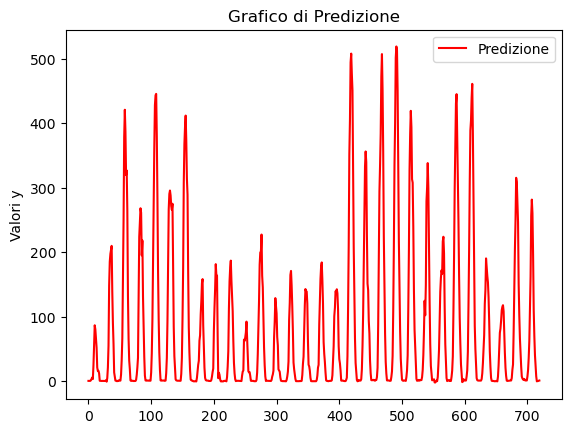

In [70]:
plt.plot(range(len(y_pred_A)), y_pred_A, label='Predizione', color='red', linestyle='-')

# Aggiungi una legenda
plt.legend()

# Aggiungi etichette agli assi
plt.ylabel('Valori y')

# Titolo del grafico
plt.title('Grafico di Predizione')

# Mostra il grafico
plt.show()

In [75]:
df = pd.DataFrame({'Prediction':y_pred_A})

In [76]:
threshold = 0.05
df['Prediction'] = df['Prediction'].apply(lambda x: 0 if x < threshold else x)

In [77]:
df.to_csv('C.csv')

In [78]:
df.head(50)


,Prediction
0,0.120171
1,0.120171
2,0.120171
3,0.125308
4,1.301581
5,3.125103
6,5.349928
7,2.846190
8,24.482791
9,55.897179
